In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

sns.set()

### Preprocessing 

In [4]:
df = pd.read_csv('PastLoans.csv')

In [5]:
df = pd.get_dummies(df)
df = df.drop(['social1', 'social2', 'id'], axis=1)

In [6]:
df.head(5)

,sex,marital,income,social3,default,employment_employed,employment_retired,employment_student,employment_unemployed
0,1,0,5458,0.732502,0,0,0,0,1
1,1,1,26108,0.615449,0,1,0,0,0
2,1,1,11810,0.174645,0,1,0,0,0
3,1,1,5375,0.216376,0,0,0,0,1
4,0,1,3459,0.346708,1,0,1,0,0


data is skewed, take log to flatten histogram

In [7]:
df['log_income'] = np.log(df['income']+1)
df = df.loc[:, df.columns != 'income']

<AxesSubplot:ylabel='Frequency'>

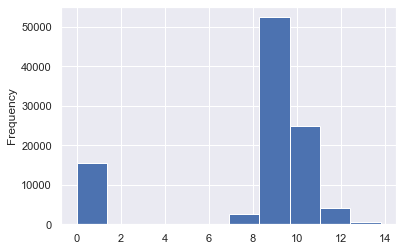

In [8]:
df.log_income.plot.hist()

In [9]:
df.describe()

,sex,marital,social3,default,employment_employed,employment_retired,employment_student,employment_unemployed,log_income
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.725190,0.610080,0.414410,0.196320,0.614850,0.112030,0.159840,0.113280,8.042560
std,0.446421,0.487734,0.324663,0.397215,0.486633,0.315405,0.366459,0.316936,3.526420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.060052,0.000000,0.000000,0.000000,0.000000,0.000000,8.669227
50%,1.000000,1.000000,0.440763,0.000000,1.000000,0.000000,0.000000,0.000000,9.191259
75%,1.000000,1.000000,0.691053,0.000000,1.000000,0.000000,0.000000,0.000000,9.807981
max,1.000000,1.000000,0.999980,1.000000,1.000000,1.000000,1.000000,1.000000,13.815512


- No missing values
- Mainly male profiles
- Mainly married persons
- Mainly employed 
- 19% of default payments

In [10]:
X = df.loc[:, df.columns != 'default']
y = df['default']

<AxesSubplot:>

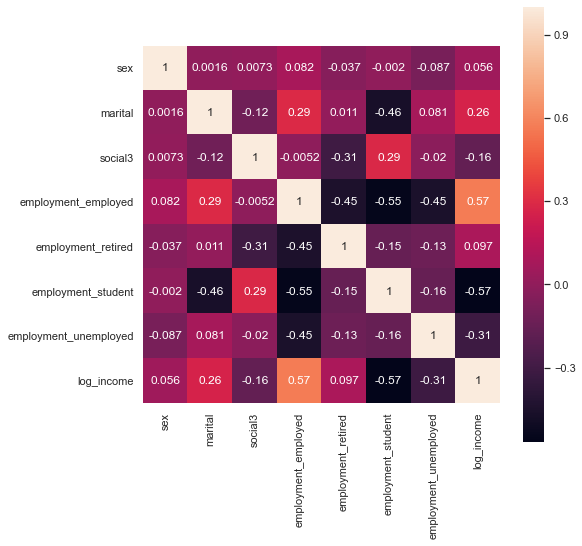

In [11]:
plt.figure(figsize=(8,8))
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=True, square=True)

Bit of multicollinearity between the indep variables, we could remove some var to remove coll

## Regression

As target is bin, better to take logistic regression. Tried with OLS and random forest, but results were worse

In [12]:
est = sm.Logit(y, sm.add_constant(X).drop(['employment_employed'], axis=1))
fit = est.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.465668
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99992
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                 0.05975
Time:                        18:20:23   Log-Likelihood:                -46567.
converged:                       True   LL-Null:                       -49526.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.7261      0.043     17.009      0.000       0.642       0.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy Score : ', accuracy_score(y_pred,y_test))

Accuracy Score :  0.80705


## Find threshold & rates

In [14]:
preds = pd.DataFrame(model.predict_proba(X_test)[:,1], columns = ['prob_default'])
preds['true_loan_status'] = list(y_test)

In [15]:
accept_rates = np.arange(0.05,0.7, 0.01)
thresholds = []
num_accepted = []
profit = []

amount = 10000  # value of loan

for r in accept_rates :
    threshold = np.quantile(preds['prob_default'], r)
    thresholds.append(threshold)
    preds['pred_loan_status'] = preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)
    num = len(preds[preds['prob_default'] < np.quantile(preds['prob_default'], r)])
    num_accepted.append(num)
    accepted_loans = preds[preds['pred_loan_status'] == 0]
    
    rates = preds['prob_default']
    preds['rates'] = np.log(1+rates)  # apply log to proba rate
    preds.loc[preds['pred_loan_status'] == 1, 'rates'] = float("Inf")
    
    loss = amount*len(preds.loc[(preds['true_loan_status'] == 1) & (preds['pred_loan_status'] == 0)])
    gain = (preds.loc[(preds['true_loan_status'] == 0) & (preds['pred_loan_status'] == 0)]['rates'] * amount).sum()
    tot = gain - loss
    profit.append(tot)

In [16]:
res = pd.DataFrame(zip(accept_rates, thresholds, num_accepted, profit), columns = 
                  ['accept_rates', 'thresholds', 'num_accepted', 'profit'])

In [17]:
res

,accept_rates,thresholds,num_accepted,profit
0,0.05,0.088062,1000,-2.000581e+05
1,0.06,0.093361,1200,-1.893034e+05
2,0.07,0.097923,1400,-1.810584e+05
3,0.08,0.101997,1600,-1.436097e+05
4,0.09,0.105182,1800,-1.254926e+03
...,...,...,...,...
60,0.65,0.196662,13000,-2.303339e+06
61,0.66,0.199018,13200,-2.520881e+06
62,0.67,0.200894,13400,-2.546542e+06
63,0.68,0.202795,13600,-2.676058e+06


442067.742897423
23
accept_rates         0.280000
thresholds           0.141717
num_accepted      5600.000000
profit          442067.742897
Name: 23, dtype: float64


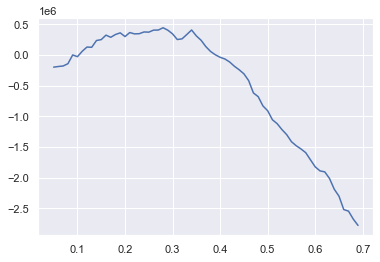

In [20]:
plt.plot(res.accept_rates, res.profit)
print(max(res.profit))
print(res['profit'].idxmax())
print(res.iloc[res['profit'].idxmax()])

Set accept rate to approx 35%

threshold :  0.15096263968274362


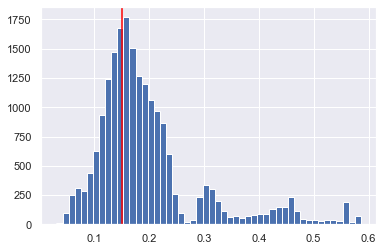

In [21]:
plt.hist(preds['prob_default'], bins = 50)
threshold = np.quantile(preds['prob_default'], 0.35)
print('threshold : ', threshold)
plt.axvline(x = threshold, color = 'red')
plt.show()

In [22]:
preds['pred_loan_status'] = preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)
print(classification_report(preds['pred_loan_status'], preds['true_loan_status']))
print(confusion_matrix(preds['pred_loan_status'], preds['true_loan_status']))
print('Accuracy Score : ', accuracy_score(preds['pred_loan_status'], preds['true_loan_status']))

              precision    recall  f1-score   support

           0       0.39      0.90      0.55      7000
           1       0.82      0.24      0.38     13000

    accuracy                           0.47     20000
   macro avg       0.61      0.57      0.46     20000
weighted avg       0.67      0.47      0.44     20000

[[6326  674]
 [9833 3167]]
Accuracy Score :  0.47465


Accuracy is worse but there is a much lower number of false positives

## Apply to dataset

In [23]:
upload = pd.read_csv('LoanApplications_Stage1_Lender3.csv')
data = upload

In [24]:
data = pd.get_dummies(data)
data = data.drop(['id'], axis=1)
data['log_income'] = np.log(data['income']+1)
data = data.loc[:, data.columns != 'income']

In [25]:
data.head(5)

,sex,marital,social3,employment_employed,employment_retired,employment_student,employment_unemployed,log_income
0,1,1,0.889338,1,0,0,0,8.960339
1,1,1,0.223372,0,1,0,0,9.136371
2,1,1,0.000000,1,0,0,0,10.149840
3,1,1,0.274015,1,0,0,0,10.962354
4,1,0,0.208616,0,1,0,0,8.279951


In [26]:
data_pred = pd.DataFrame(model.predict_proba(data)[:,1], columns = ['prob_default'])
data_pred['pred_loan_status'] = data_pred['prob_default'].apply(lambda x: 1 if x > threshold else 0)
rate = data_pred['prob_default']
data_pred['rate'] = np.log(1+rate)
data_pred.loc[data_pred['pred_loan_status'] == 1, 'rate'] = float("Inf")

In [27]:
data_pred

,prob_default,pred_loan_status,rate
0,0.131307,0,0.123374
1,0.162770,1,inf
2,0.188638,1,inf
3,0.138060,0,0.129325
4,0.204732,1,inf
...,...,...,...
99995,0.146552,0,0.136759
99996,0.290518,1,inf
99997,0.161232,1,inf
99998,0.101985,0,0.097113


(array([   5.,    4.,   13.,   46.,   59.,  155.,  230.,  388.,  492.,
         596.,  615.,  623.,  633.,  600.,  678.,  709.,  787.,  909.,
        1081., 1338., 1577., 1659., 1948., 2305., 2516., 2864., 3007.,
        3181., 3411., 3384.]),
 array([0.02384225, 0.02773413, 0.03162601, 0.03551789, 0.03940977,
        0.04330165, 0.04719353, 0.05108541, 0.05497729, 0.05886917,
        0.06276105, 0.06665293, 0.07054481, 0.07443669, 0.07832857,
        0.08222045, 0.08611233, 0.09000421, 0.09389609, 0.09778797,
        0.10167985, 0.10557173, 0.10946361, 0.11335549, 0.11724737,
        0.12113925, 0.12503113, 0.12892301, 0.13281489, 0.13670677,
        0.14059865]),
 <BarContainer object of 30 artists>)

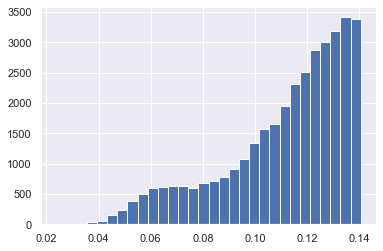

In [28]:
plt.hist(data_pred[data_pred != float("Inf")]['rate'], bins = 30)

In [29]:
upload['rate'] = round(data_pred['rate'],2)

In [30]:
upload

,id,sex,employment,marital,income,social3,rate
0,100001,1,employed,1,7787,0.889338,0.12
1,100002,1,retired,1,9286,0.223372,inf
2,100003,1,employed,1,25586,0.000000,inf
3,100004,1,employed,1,57661,0.274015,0.13
4,100005,1,retired,0,3943,0.208616,inf
...,...,...,...,...,...,...,...
99995,199996,1,retired,0,22188,0.279188,0.14
99996,199997,1,student,0,0,0.984142,inf
99997,199998,1,employed,1,5615,0.659528,inf
99998,199999,1,unemployed,1,16573,0.557966,0.10


In [31]:
upload.to_csv('pred_Stage1_Lender3',index=False)